#Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing Libraries

In [ ]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve, auc

import seaborn as sns

#Loading and Merging Dataset

In [ ]:
train_outpatientdata = '/content/drive/Shared drives/IS 734/Data/Train_Outpatientdata.csv'
train_inpatientdata = '/content/drive/Shared drives/IS 734/Data/Train_Inpatientdata.csv'
train_beneficiarydata = '/content/drive/Shared drives/IS 734/Data/Train_Beneficiarydata.csv'
train_data = '/content/drive/Shared drives/IS 734/Data/TrainData.csv'


# Load the CSV file into a pandas DataFrame
df1 = pd.read_csv(train_outpatientdata)
df2 = pd.read_csv(train_inpatientdata)
df3 = pd.read_csv(train_beneficiarydata)
df4 = pd.read_csv(train_data)

#merging the training dataset
merged_data = pd.concat([df1,df2])
merged_data = pd.merge(merged_data, df4, on="Provider", how="outer")
merged_data = pd.merge(merged_data, df3, on="BeneID")
final_train = merged_data.fillna(0)


#Data Preprocessing

In [ ]:
df = final_train.copy()

# Handle missing values in the entire DataFrame
df = df.fillna('missing_value')

# Identify categorical columns
catcols = df.select_dtypes(include=['object']).columns.tolist()

# Exclude columns that may cause issues
exclude_cols = ['PotentialFraud']

catcols = [col for col in catcols if col not in exclude_cols]

le = {}
for i in catcols:
    print(i)
    # Handle missing values by filling them with a placeholder
    df[i] = df[i].fillna('missing_value')

    # Convert the column to string type
    df[i] = df[i].astype(str)
    le[i] = preprocessing.LabelEncoder()
    df[i] = le[i].fit_transform(df[i])

BeneID
ClaimID
ClaimStartDt
ClaimEndDt
Provider
AttendingPhysician
OperatingPhysician
OtherPhysician
ClmDiagnosisCode_1
ClmDiagnosisCode_2
ClmDiagnosisCode_3
ClmDiagnosisCode_4
ClmDiagnosisCode_5
ClmDiagnosisCode_6
ClmDiagnosisCode_7
ClmDiagnosisCode_8
ClmDiagnosisCode_9
ClmDiagnosisCode_10
ClmAdmitDiagnosisCode
AdmissionDt
DischargeDt
DiagnosisGroupCode
DOB
DOD
RenalDiseaseIndicator


# Data Imbalance Plot

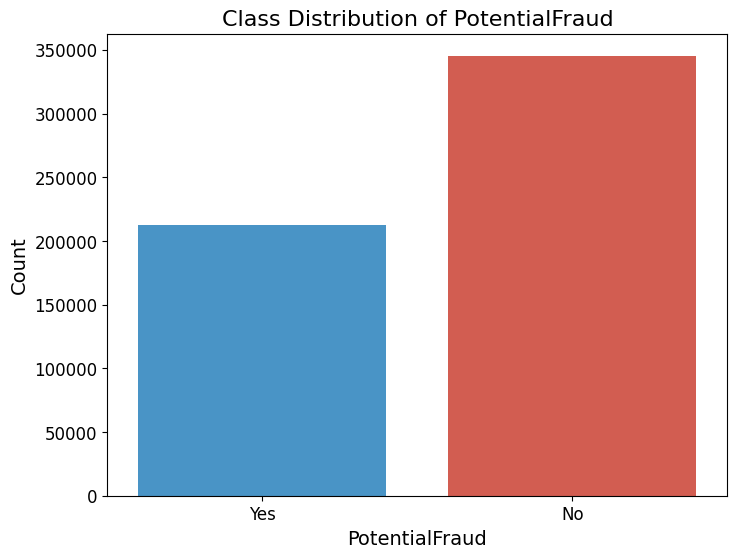

In [ ]:
# Assuming PotentialFraud is the target variable in your DataFrame
target_variable = "PotentialFraud"

# Set custom colors
colors = ["#3498db", "#e74c3c"]

# Plot the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=target_variable, data=df, palette=colors)
plt.title('Class Distribution of PotentialFraud', fontsize=16)
plt.xlabel('PotentialFraud', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


# Preparing Data For Training

In [ ]:
X = df.drop("PotentialFraud", axis=1)  # Drop the target column
Y = df["PotentialFraud"].apply(lambda x: True if x == "Yes" else False)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

In [ ]:
# Perform over-sampling using SMOTE on the training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

#Building Random Forest Classifier

In [ ]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[29141  5474]
 [ 7635 13560]]

Classification Report:
               precision    recall  f1-score   support

       False       0.79      0.84      0.82     34615
        True       0.71      0.64      0.67     21195

    accuracy                           0.77     55810
   macro avg       0.75      0.74      0.75     55810
weighted avg       0.76      0.77      0.76     55810



#Precision-Recall Curve

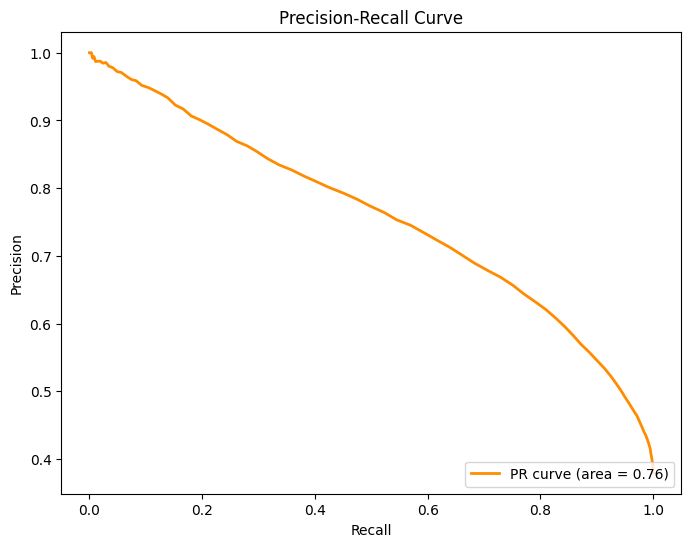

In [ ]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, rf_classifier.predict_proba(X_test)[:, 1])
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()

#Confusion Matrix HeatMap

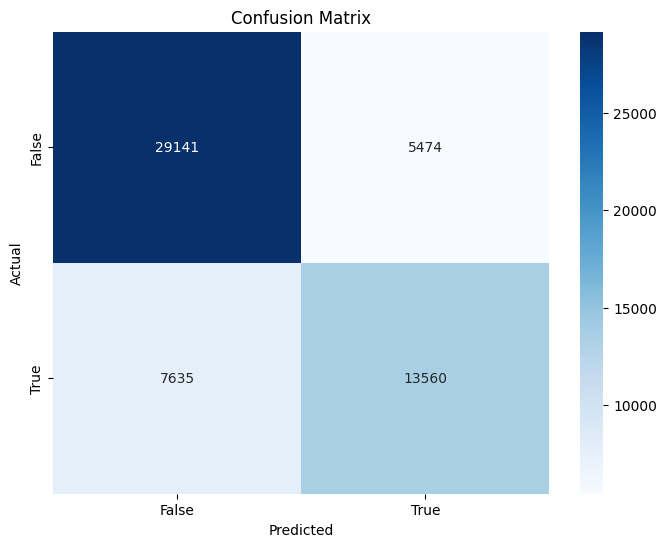

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#ROC Curve

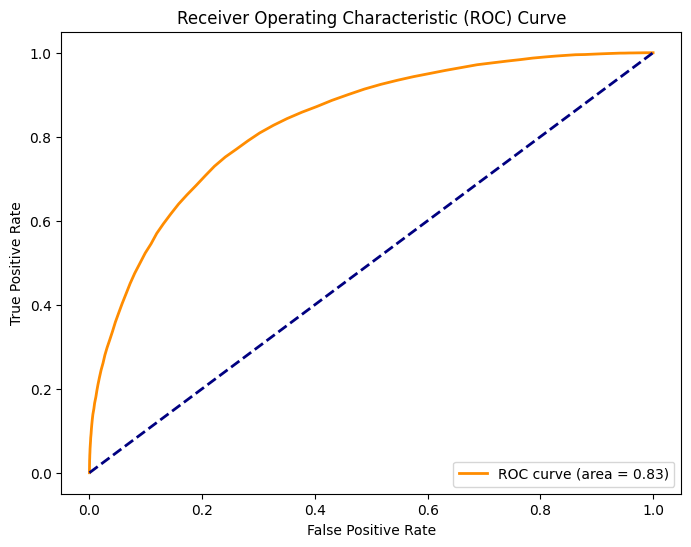

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, rf_classifier.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#Feature Ranking

Feature Ranking:
                            Feature    Importance
4                          Provider  1.092921e-01
36                           County  7.069202e-02
35                            State  5.865272e-02
6                AttendingPhysician  5.678768e-02
30                              DOB  4.728544e-02
0                            BeneID  4.492772e-02
9                ClmDiagnosisCode_1  4.445320e-02
52         OPAnnualReimbursementAmt  4.440194e-02
53            OPAnnualDeductibleAmt  4.233519e-02
1                           ClaimID  4.076121e-02
5            InscClaimAmtReimbursed  3.822318e-02
2                      ClaimStartDt  3.756806e-02
3                        ClaimEndDt  3.749298e-02
10               ClmDiagnosisCode_2  3.667875e-02
8                    OtherPhysician  2.518209e-02
11               ClmDiagnosisCode_3  2.442462e-02
50         IPAnnualReimbursementAmt  1.901913e-02
26            ClmAdmitDiagnosisCode  1.883460e-02
12               ClmDiagnosisCode

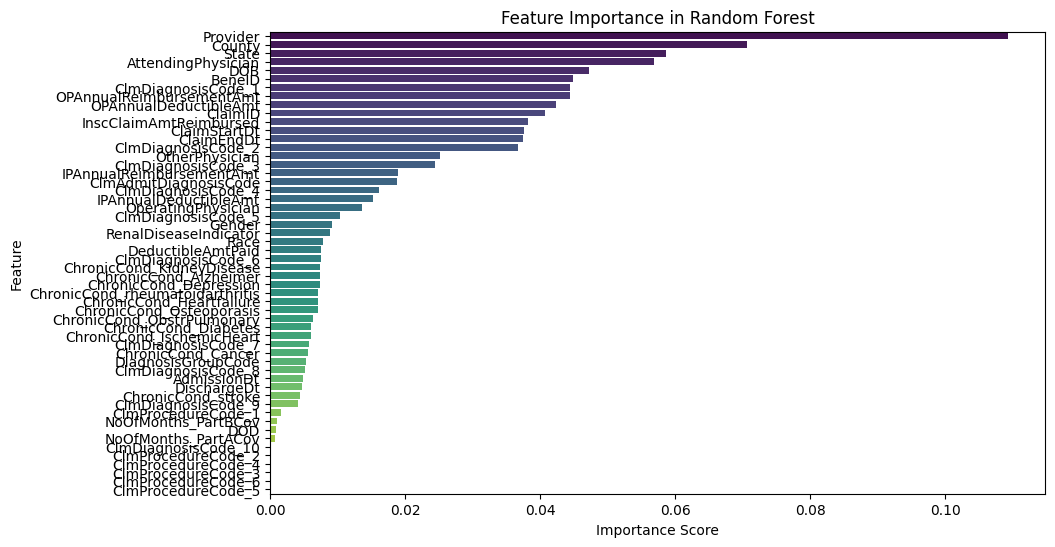

In [ ]:
# Access feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame to display feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature ranking
print("Feature Ranking:")
print(feature_importance_df)

# Plot a bar chart to visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance in Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()
